## Sentiment Analysis  

### Naïve Bayes Classifier using Bag-of-Words

## Setup & Reproducibility:
* Import core libraries 
* Configure a single SEEd for reproducible slits, shuffling, and model init

In [ ]:

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OMP_NUM_THREADS"] = "8"  
os.environ["MKL_NUM_THREADS"] = "8"

import torch
torch.set_num_threads(8)
torch.set_num_interop_threads(2)  


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,recall_score,precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import os, random, numpy as np, torch

SEED = 42
random.seed(SEED); np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Load IMDB Sentiment Dataset 
* Load dataset of 50,000 IMDB movie reviews from CSV file
* Each row contains a review and a binary sentiment label (positive/negative)

In [ ]:
df = pd.read_csv("data/IMDB Dataset.csv")

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Text Cleaning and Normalization
* We clean raw IMDB reviews for use in classical models (Naive Bayes, TF-IDF + LogReg, etc.)
* We remove the following:
    1. HTML tags 
    2. Punctuations
    3. Convert to lowercase for normalization 
* For transformer models (BERT/ RoBERTa), we will use raw reviews instead of clean reviews, tokenizaers have already handle casing and punctuations. 


In [ ]:
import re
import string

def clean_text(text: str) -> str:
    """
    1. Remove HTML tags
    2. Remove punctuations 
    3. Convert text to lower case 
    """
    text = re.sub('<.*?>', '', text) 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

df['clean_review'] = df['review'].apply(clean_text)
df.head()


,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


## Baseline 1: Bag-of-Words (CountVectorizer) + Multinomial Naive Bayes
* Split: stratified 80/20 using SEED for reproducibility 
* Features: unigram Bag-of-Words with English stop words, cap vocab to 5000 most frequent terms 
* Model: Multinomial Naive Bayes
* Metrics: Accuracy, F1-macro, precision, recall and confusion matrix 

BoW ready. Train shape: (40000, 5000), Test shape: (10000, 5000)
Vectorization time: 3.60s
_________Multinomial NB (BoW) Results_________
Test Accuracy: 0.8453
F1-macro: 0.8453  |  Precision-macro: 0.8453  |  Recall-macro: 0.8453
Train time: 0.04s  |  Inference time: 0.00s

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.85      0.85      5000
    positive       0.85      0.84      0.84      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



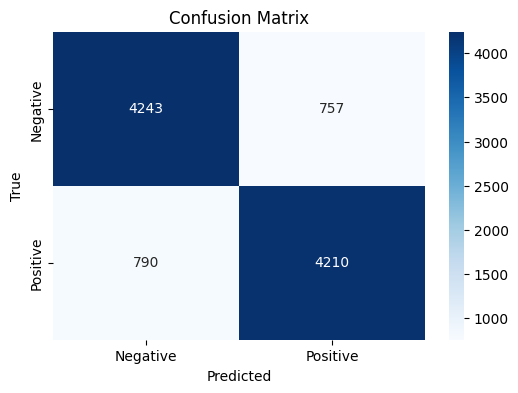

In [ ]:
from time import perf_counter

X = df['clean_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=SEED,
                                                    stratify=y)

vectorizer = CountVectorizer(stop_words='english', max_features=5000)

t0 = perf_counter()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
vec_time = perf_counter()-t0

print(f"BoW ready. Train shape: {X_train_bow.shape}, Test shape: {X_test_bow.shape}")
print(f"Vectorization time: {vec_time:.2f}s")

nb_classifier = MultinomialNB(alpha=1.0)

t0 = perf_counter()
nb_classifier.fit(X_train_bow, y_train)
train_time = perf_counter() - t0

t0 = perf_counter()
y_pred = nb_classifier.predict(X_test_bow)
infer_time = perf_counter() - t0

acc = accuracy_score(y_test, y_pred)
f1m = f1_score (y_test, y_pred, average="macro", pos_label=None)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred, average="macro",zero_division=0)

print(f"_________Multinomial NB (BoW) Results_________")
print(f"Test Accuracy: {acc:.4f}")
print(f"F1-macro: {f1m:.4f}  |  Precision-macro: {prec:.4f}  |  Recall-macro: {rec:.4f}")
print(f"Train time: {train_time:.2f}s  |  Inference time: {infer_time:.2f}s")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))

cm = confusion_matrix(y_test, y_pred, labels=["negative", "positive"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Baseline 2: TF-IDF + Multinomial Naive Bayes

_________Multinomial NB (TF-IDF) Results_________
Accuracy: 0.8540  |  F1-macro: 0.8540  |        Precision-macro: 0.8541  |  Recall-macro: 0.8540
Vectorize: 3.64s  |  Train: 0.04s  |  Infer(test): 0.00s

Classification Report (TF-IDF):
              precision    recall  f1-score   support

    Negative       0.86      0.85      0.85      5000
    Positive       0.85      0.86      0.86      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



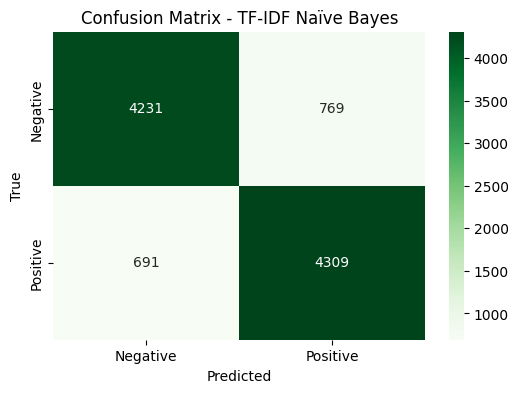

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

t0 = perf_counter()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
vec_time = perf_counter() - t0


nb_tfidf = MultinomialNB(alpha=1.0)

t0 = perf_counter() 
nb_tfidf.fit(X_train_tfidf, y_train)
train_time = perf_counter() - t0

t0 = perf_counter()
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)
infer_time = perf_counter() - t0

acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
prec_tfidf = precision_score(y_test, y_pred_tfidf, average="macro", zero_division=0)
rec_tfidf  = recall_score(y_test, y_pred_tfidf, average="macro", zero_division=0)
f1m_tfidf  = f1_score(y_test, y_pred_tfidf, average="macro")

print(f"_________Multinomial NB (TF-IDF) Results_________")
print(f"Accuracy: {acc_tfidf:.4f}  |  F1-macro: {f1m_tfidf:.4f}  |  \
      Precision-macro: {prec_tfidf:.4f}  |  Recall-macro: {rec_tfidf:.4f}")
print(f"Vectorize: {vec_time:.2f}s  |  Train: {train_time:.2f}s  |  Infer(test): {infer_time:.2f}s")

print("\nClassification Report (TF-IDF):")
print(classification_report(y_test, y_pred_tfidf, target_names=["Negative", "Positive"]))

cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, labels=["negative", "positive"])

plt.figure(figsize=(6,4))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - TF-IDF Naïve Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



## Small Dataset Performance Evaluation (3k training samples)
To understand how different transformer architectures behave when training on a limited dataset, we compare 4 widely used pretrained models:
* DistilBERT (distilbert-base-uncased)
* BERT (bert-base-uncased)
* RoBERTa (roberta-base)
* ALBERT (albert-base-v2)

All models were fine tuned under identical conditions:
* 3000 training samples
* 1000 validation samples
* 1000 test samples
* Batch size 8
* Max 3 epochs
* Metrics: F1 score and Accuracy

In [ ]:
import pandas as pd
import numpy as np
import torch
import evaluate

from datasets import Dataset, DatasetDict

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)

from tqdm import tqdm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" 

df = pd.read_csv("data/IMDB Dataset.csv")

df["label"] = df["sentiment"].map({"positive": 1, "negative": 0}).astype(int)
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)  # shuffle

train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=SEED, stratify=train_df["label"])

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds = Dataset.from_pandas(val_df, preserve_index=False)
test_ds = Dataset.from_pandas(test_df, preserve_index=False)
dataset = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})

def safe_select(ds, n):
    n = min(n, len(ds))
    return ds.select(range(n))

dataset_small = DatasetDict({
    "train":        safe_select(dataset["train"], 3000),        # 3k train
    "validation":   safe_select(dataset["validation"], 1000),  # 1k validation
    "test":         safe_select(dataset["test"], 1000),           # 1k test
})

print(dataset_small)


Train size: 36000 | Val size: 4000 | Test size: 10000
DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'label'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'label'],
        num_rows: 1000
    })
})


In [ ]:
import os, pandas as pd
from datasets import DatasetDict, load_from_disk

tokenized_cache = {} 
CACHE_DIR = "./hf_ds_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def key_for(model_ckpt):
    if "roberta" in model_ckpt:
        return "roberta-base"
    if "albert" in model_ckpt:
        return "albert-base-v2"
    return "bert-base-uncased"

def get_tokenized_ds(model_ckpt):
    k = key_for(model_ckpt)
    disk_path = os.path.join(CACHE_DIR, k)
    if k in tokenized_cache:
        return tokenized_cache[k]
    if os.path.isdir(disk_path):
        ds = load_from_disk(disk_path)
        tokenized_cache[k] = ds
        return ds

    tok = AutoTokenizer.from_pretrained(k, use_fast=True)

    def preprocess_fn(batch):
        return tok(batch["review"], truncation=True)

    ds = dataset_small.map(
        preprocess_fn, batched=True,
        remove_columns=[c for c in dataset_small["train"].column_names if c not in {"label"}],
        num_proc=4  
    )
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    ds.save_to_disk(disk_path)
    tokenized_cache[k] = ds
    return ds


In [9]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)
    f1_score = f1.compute(predictions=preds, references=labels, average="macro")
    return {"accuracy": acc["accuracy"], "f1": f1_score["f1"]}

models_to_compare = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    "roberta-base",
    "albert-base-v2",
]



In [ ]:
results = []
training_logs = {}

for model_ckpt in models_to_compare:
    print(f"\nTraining model: {model_ckpt}")

    tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)

    tokenized_ds = get_tokenized_ds(model_ckpt)           
    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)

    args = TrainingArguments(
        output_dir=f"./results/{model_ckpt.split('/')[-1]}",
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        learning_rate=2e-5,
        dataloader_num_workers=4,
        dataloader_prefetch_factor=4,
        dataloader_persistent_workers=True,  
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        group_by_length=True,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none",
        dataloader_pin_memory=False,
        seed=SEED,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["validation"],
        tokenizer=tokenizer,          
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()

    # save best model 
    save_dir = f"./saved_models/{model_ckpt.split('/')[-1]}"
    trainer.save_model(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"Final model saved to {save_dir}")

    eval_result = trainer.evaluate()
    results.append({
        "Model": model_ckpt,
        "Accuracy": float(eval_result.get("eval_accuracy", 0.0)),
        "F1": float(eval_result.get("eval_f1", 0.0))
    })
    training_logs[model_ckpt] = pd.DataFrame(trainer.state.log_history)

pd.DataFrame(results).sort_values("F1", ascending=False).reset_index(drop=True)



Training model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/k8/v2j44j5n7xb7r19bz_rsjf8r0000gn/T/ipykernel_20114/2686310390.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.391200,0.328179,0.887000,0.886877
2,0.186500,0.478251,0.876000,0.875490
3,0.121100,0.445755,0.903000,0.902999


Final model saved to ./saved_models/distilbert-base-uncased



Training model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/k8/v2j44j5n7xb7r19bz_rsjf8r0000gn/T/ipykernel_20114/2686310390.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.374600,0.384007,0.882000,0.881314
2,0.191200,0.430265,0.905000,0.904931
3,0.085600,0.461790,0.912000,0.912000


Final model saved to ./saved_models/bert-base-uncased



Training model: roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/3000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/k8/v2j44j5n7xb7r19bz_rsjf8r0000gn/T/ipykernel_20114/2686310390.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.392400,0.309281,0.926000,0.925997
2,0.215700,0.293315,0.930000,0.930000
3,0.107900,0.364161,0.928000,0.927977


Final model saved to ./saved_models/roberta-base



Training model: albert-base-v2


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/3000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/k8/v2j44j5n7xb7r19bz_rsjf8r0000gn/T/ipykernel_20114/2686310390.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.421600,0.335213,0.898000,0.897959
2,0.275700,0.457224,0.907000,0.906973
3,0.176400,0.414474,0.916000,0.915997


Final model saved to ./saved_models/albert-base-v2


,Model,Accuracy,F1
0,roberta-base,0.930,0.930000
1,albert-base-v2,0.916,0.915997
2,bert-base-uncased,0.912,0.912000
3,distilbert-base-uncased,0.903,0.902999


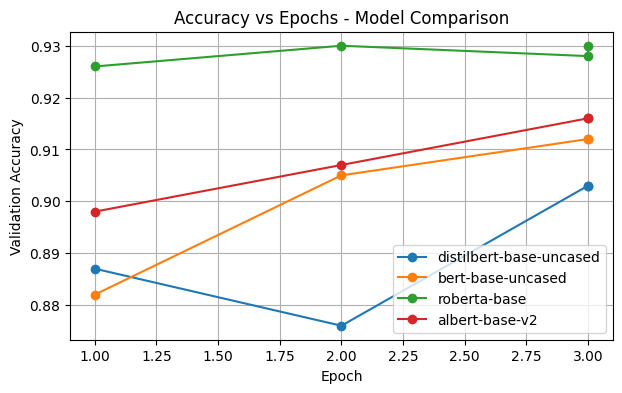

In [12]:
plt.figure(figsize=(7,4))
for model_ckpt, logs in training_logs.items():
    eval_logs = logs[logs["epoch"].notnull() & logs["eval_accuracy"].notnull()]
    plt.plot(eval_logs["epoch"], eval_logs["eval_accuracy"], marker="o", label=model_ckpt)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Epochs - Model Comparison")
plt.legend()
plt.grid(True)
plt.show()


📊 Model Comparison Results:


,Model,Accuracy,F1
0,distilbert-base-uncased,0.903,0.902999
1,bert-base-uncased,0.912,0.912000
2,roberta-base,0.930,0.930000
3,albert-base-v2,0.916,0.915997


/var/folders/k8/v2j44j5n7xb7r19bz_rsjf8r0000gn/T/ipykernel_20114/3781524906.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


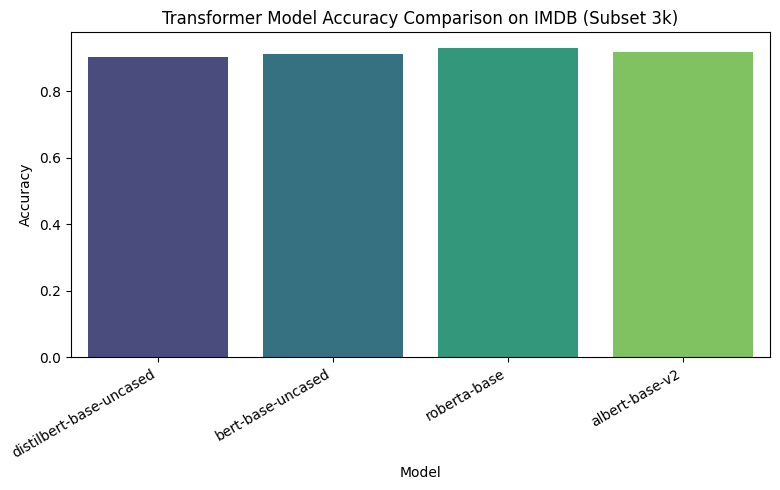

/var/folders/k8/v2j44j5n7xb7r19bz_rsjf8r0000gn/T/ipykernel_20114/3781524906.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1", data=results_df, palette="mako")


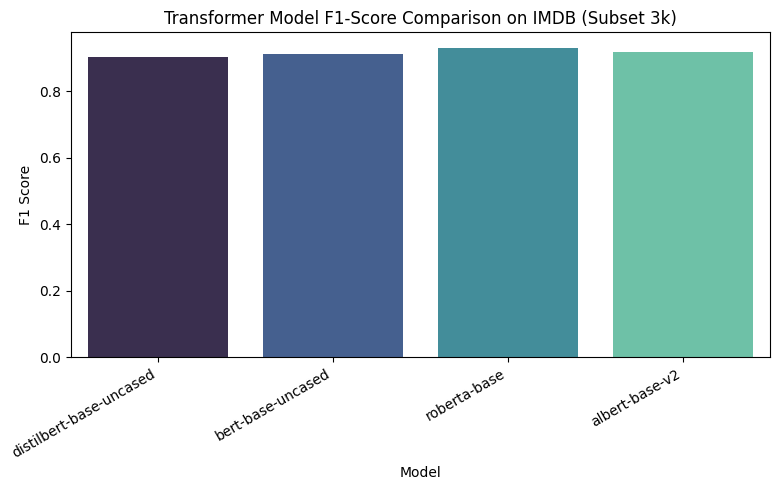

In [ ]:
results_df = pd.DataFrame(results)
print("\nModel Comparison Results:")
display(results_df)

# Plot Accuracy Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Transformer Model Accuracy Comparison on IMDB (Subset 3k)")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Plot F1 Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="F1", data=results_df, palette="mako")
plt.title("Transformer Model F1-Score Comparison on IMDB (Subset 3k)")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


📈 Final Model Comparison:


,Model,Accuracy,F1
0,distilbert-base-uncased,0.903,0.902999
1,bert-base-uncased,0.912,0.912000
2,roberta-base,0.930,0.930000
3,albert-base-v2,0.916,0.915997


/var/folders/k8/v2j44j5n7xb7r19bz_rsjf8r0000gn/T/ipykernel_20114/3492888570.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


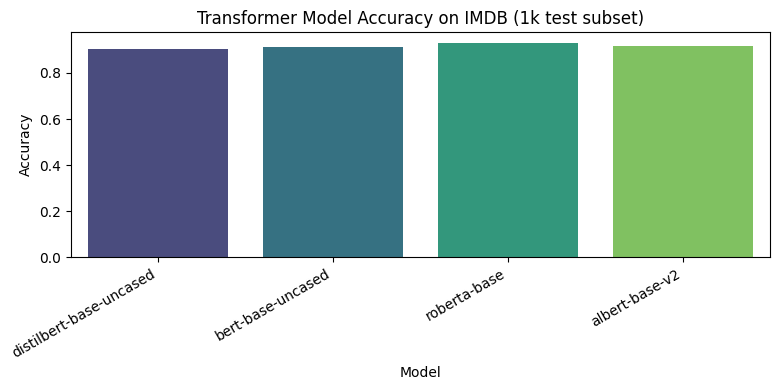

/var/folders/k8/v2j44j5n7xb7r19bz_rsjf8r0000gn/T/ipykernel_20114/3492888570.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1", data=results_df, palette="mako")


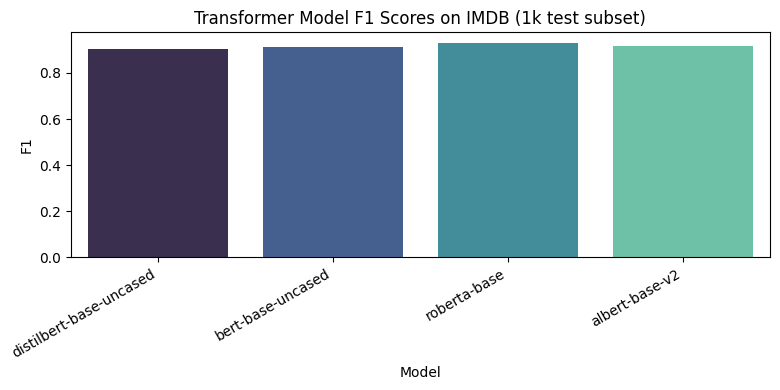

In [ ]:
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison:")
display(results_df)

plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Transformer Model Accuracy on IMDB (1k test subset)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="F1", data=results_df, palette="mako")
plt.title("Transformer Model F1 Scores on IMDB (1k test subset)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

## Regularized DistilBERT Fine-Tuning (3k / 1k / 1k Dataset)
This experiment fine-tunes DistilBERT (distilbert-base-uncased) on a small IMDB subset using additional regularization techniques to reduce overfitting.

We create a modified DistilBERT configuration with increased dropout and attention dropout:
* Default dropout ≈ 0.1
* Increased to 0.3 for stronger regularization
* Helps reduce overfitting on small datasets
* Increase weight decay, improve generalization 

In [ ]:
import random
from transformers import AutoConfig, AutoModelForSequenceClassification

model_ckpt = "distilbert-base-uncased"

tokenized_ds = get_tokenized_ds(model_ckpt)

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

def build_regularized_distilbert(ckpt: str):
    """
    Build a DistilBERT model with higher dropout 
    to reduce overfitting on small data.
    """
    config = AutoConfig.from_pretrained(
        ckpt,
        num_labels=2,
        dropout=0.3,            
        attention_dropout=0.3,
    )
    model = AutoModelForSequenceClassification.from_pretrained(
        ckpt,
        config=config,
    )
    return model


model = build_regularized_distilbert(model_ckpt)

args = TrainingArguments(
    output_dir=f"./results/{model_ckpt.split('/')[-1]}",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    learning_rate=2e-5,
    dataloader_num_workers=4,
    dataloader_prefetch_factor=4,
    dataloader_persistent_workers=True,  
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    group_by_length=True,
    num_train_epochs=3,
    weight_decay=0.07,
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    dataloader_pin_memory=False,
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

trainer.train()

save_dir = "./saved_models/distilbert-regularized"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"Regularized DistilBERT saved to: {save_dir}")

eval_result = trainer.evaluate()
print("Final eval metrics:", eval_result)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/k8/v2j44j5n7xb7r19bz_rsjf8r0000gn/T/ipykernel_32617/944806526.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.459000,0.308964,0.887000,0.887000
2,0.284200,0.367491,0.887000,0.886828


Regularized DistilBERT saved to: ./saved_models/distilbert-regularized


Final eval metrics: {'eval_loss': 0.30896446108818054, 'eval_accuracy': 0.887, 'eval_f1': 0.886999886999887, 'eval_runtime': 29.6336, 'eval_samples_per_second': 33.745, 'eval_steps_per_second': 4.218, 'epoch': 2.0}


## Domain adaption: Adapting DistilBERT (IMDB) to Twitter Sentiment (3k / 1k / 1k)

This experiment adapts the previously fine-tuned DistilBER (distilbert-regularized) model, originally trained on IMDB movie reviews—to a new domain: Twitter.

Twitter text differs significantly from IMDB reviews in writing style, vocabulary, slang, and sentiment expression.

Therefore, domain adaptation is needed to improve performance on this new target domain.

We perform adaptation using a controlled subset of:

* 3,000 training tweets
* 1,000 validation tweets
* 1,000 test tweets

Only Positive and Negative sentiment classes are considered to align with the IMDB binary classifier.

In [ ]:
import pandas as pd
import numpy as np
import torch
import random

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = pd.read_csv("data/twitter_training.csv", header=None)
df.columns = ["id", "topic", "sentiment", "text"]

df = df.dropna(subset=["sentiment", "text"]).copy()

df["sentiment_lower"] = df["sentiment"].str.lower()
df = df[df["sentiment_lower"].isin(["positive", "negative"])].copy()

df["text"] = df["text"].astype(str)

df["label"] = df["sentiment_lower"].map({"positive": 1, "negative": 0})

df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)


print("Total usable tweets:", len(df))


def safe_select(df, n):
    return df.head(min(n, len(df)))

train_df  = safe_select(df.iloc[:3000], 3000)
val_df    = safe_select(df.iloc[3000:4000], 1000)
test_df   = safe_select(df.iloc[4000:5000], 1000)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df,   preserve_index=False)
test_ds  = Dataset.from_pandas(test_df,  preserve_index=False)

twitter_ds = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})


base_model_dir = "./saved_models/distilbert-regularized"
tokenizer = AutoTokenizer.from_pretrained(base_model_dir, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(base_model_dir)

collator = DataCollatorWithPadding(tokenizer=tokenizer)


def preprocess_fn(batch):
    # make sure everything is a string
    texts = [str(t) for t in batch["text"]]
    return tokenizer(texts, truncation=True, max_length=128)

twitter_tokenized = twitter_ds.map(
    preprocess_fn,
    batched=True,
    remove_columns=["id", "topic", "sentiment", "text", "sentiment_lower"],
)


twitter_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])


args = TrainingArguments(
    output_dir="./results/distilbert_twitter_3k",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    learning_rate=1e-5,
    weight_decay=0.05,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    dataloader_num_workers=2,
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=twitter_tokenized["train"],
    eval_dataset=twitter_tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

trainer.train()

save_dir = "./saved_models/distilbert-regularized-twitter-3k"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print("\nSaved domain-adapted model to:", save_dir)


test_metrics = trainer.evaluate(twitter_tokenized["test"])
print("\nTwitter Test Metrics:", test_metrics)


Total usable tweets: 43013
Train: 3000 | Val: 1000 | Test: 1000


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/var/folders/k8/v2j44j5n7xb7r19bz_rsjf8r0000gn/T/ipykernel_32617/1022165238.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.452100,0.435106,0.817000,0.816523
2,0.377600,0.448667,0.832000,0.831220
3,0.327800,0.471710,0.833000,0.832105


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Saved domain-adapted model to: ./saved_models/distilbert-regularized-twitter-3k


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Twitter Test Metrics: {'eval_loss': 0.4508730471134186, 'eval_accuracy': 0.85, 'eval_f1': 0.8498053477306589, 'eval_runtime': 23.3903, 'eval_samples_per_second': 42.753, 'eval_steps_per_second': 5.344, 'epoch': 3.0}
